#Data


In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
! pip install arch
from arch import arch_model
import warnings
warnings.filterwarnings("ignore")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 907 kB 19.5 MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data_1 = pd.read_csv('/content/drive/MyDrive/7811 Final Project/MOM_MTUM_SPY.csv')
data_1['date'] = pd.to_datetime(data_1['date'])
data_1

,date,MOM-adjclose,MTUM-adjclose,SPY-adjclose
0,2013-04-18,24.485399,45.117134,128.588257
1,2013-04-19,24.379999,45.117134,129.706116
2,2013-04-22,24.777500,45.117134,130.281738
3,2013-04-23,24.999901,46.268970,131.624847
4,2013-04-24,24.747801,45.684181,131.708282
...,...,...,...,...
1996,2021-03-23,21.536600,156.233109,379.478882
1997,2021-03-24,21.536600,152.366104,377.549774
1998,2021-03-25,21.536600,152.074951,379.673676
1999,2021-03-26,21.536600,154.781479,385.792145


In [4]:
data_2 = pd.read_excel('/content/drive/MyDrive/7811 Final Project/MomentumDJTMNMO.xlsx',
                       skiprows = 6, usecols= 'A:B').iloc[:-1, :]
data_2['Effective date '] = pd.to_datetime(data_2['Effective date '])
data_2.rename(columns={
    'Effective date ': 'date',
    'Dow Jones U.S. Thematic Market Neutral Momentum Total Return Index': 'DJTMNMO-TR-adjclose',
}, inplace=True)
data_2.dropna(inplace=True)
data_2

,date,DJTMNMO-TR-adjclose
0,2010-04-30,957.32
1,2010-05-01,957.32
2,2010-05-02,957.32
3,2010-05-03,972.82
4,2010-05-04,959.97
...,...,...
2852,2020-05-05,1363.20
2853,2020-05-06,1372.54
2854,2020-05-07,1373.43
2855,2020-05-08,1355.27


In [5]:
data_3 = pd.read_csv("/content/drive/MyDrive/7811 Final Project/Replicate_DJTMNMO.csv")
data_3['date'] = pd.to_datetime(data_3['date'])
data_3.rename(columns = {
    'Replicate DJTMNMO-TR-m0': 'Rep-DJ-adjclose'
}, inplace=True)

In [6]:
data = pd.merge(data_1, data_3, how='inner', on='date')
data.to_csv('/content/drive/MyDrive/7811 Final Project/MOM_MTUM_SPY_DJMNM.csv', index=False)
data

,date,MOM-adjclose,MTUM-adjclose,SPY-adjclose,Rep-DJ-adjclose
0,2014-02-04,25.209999,51.677876,148.609283,0.003909
1,2014-02-05,25.440001,51.516605,148.422867,-0.001051
2,2014-02-06,25.341101,52.116886,150.380142,0.004828
3,2014-02-07,25.600901,53.227856,152.244186,0.007525
4,2014-02-10,25.522499,53.299538,152.523880,0.000526
...,...,...,...,...,...
1573,2020-05-05,29.392700,115.898560,274.425964,0.005691
1574,2020-05-06,29.174999,115.869461,272.565735,0.005530
1575,2020-05-07,29.318501,116.703896,275.854675,-0.004055
1576,2020-05-08,29.309099,118.033165,280.419098,-0.004025


In [7]:
data_pct = data
data_pct[['MOM-adjclose', 'MTUM-adjclose', 'SPY-adjclose']] = data[['MOM-adjclose', 'MTUM-adjclose', 'SPY-adjclose']].pct_change()
data_pct = data_pct.iloc[1:, :]
data_pct.reset_index(drop=True, inplace=True)
data_pct

,date,MOM-adjclose,MTUM-adjclose,SPY-adjclose,Rep-DJ-adjclose
0,2014-02-05,0.009123,-0.003121,-0.001254,-0.001051
1,2014-02-06,-0.003888,0.011652,0.013187,0.004828
2,2014-02-07,0.010252,0.021317,0.012396,0.007525
3,2014-02-10,-0.003062,0.001347,0.001837,0.000526
4,2014-02-11,-0.009815,0.013448,0.010944,0.005001
...,...,...,...,...,...
1572,2020-05-05,0.026281,0.015818,0.009239,0.005691
1573,2020-05-06,-0.007407,-0.000251,-0.006779,0.005530
1574,2020-05-07,0.004919,0.007202,0.012067,-0.004055
1575,2020-05-08,-0.000321,0.011390,0.016546,-0.004025


# Question 4:Quantitative strategy trading momentum factor while being market neutral
https://arch.readthedocs.io/en/latest/univariate/univariate_volatility_modeling.html

In [8]:
col_name = 'Rep-DJ-adjclose'

In [9]:
# generate previous market volatility
data_pct['Sig^2_m_t'] = data_pct["SPY-adjclose"].rolling(126).std()
data_pct['Sig^2_m_t-1'] = data_pct['Sig^2_m_t'].shift(1)
data_pct['Sig^2_m_t-1'] = 22 * data_pct['Sig^2_m_t-1'] ** 2
data_pct['Sig^2_m_t'] = 22 * data_pct['Sig^2_m_t'] ** 2
data_pct

,date,MOM-adjclose,MTUM-adjclose,SPY-adjclose,Rep-DJ-adjclose,Sig^2_m_t,Sig^2_m_t-1
0,2014-02-05,0.009123,-0.003121,-0.001254,-0.001051,NaN,NaN
1,2014-02-06,-0.003888,0.011652,0.013187,0.004828,NaN,NaN
2,2014-02-07,0.010252,0.021317,0.012396,0.007525,NaN,NaN
3,2014-02-10,-0.003062,0.001347,0.001837,0.000526,NaN,NaN
4,2014-02-11,-0.009815,0.013448,0.010944,0.005001,NaN,NaN
...,...,...,...,...,...,...,...
1572,2020-05-05,0.026281,0.015818,0.009239,0.005691,0.015594,0.015594
1573,2020-05-06,-0.007407,-0.000251,-0.006779,0.005530,0.015599,0.015594
1574,2020-05-07,0.004919,0.007202,0.012067,-0.004055,0.015625,0.015599
1575,2020-05-08,-0.000321,0.011390,0.016546,-0.004025,0.015673,0.015625


In [10]:
# generate bear market indicator
## year month indicator
data_pct['ym'] = data_pct['date'].dt.year * 100 + data_pct['date'].dt.month
## days for 24 months period
bear_lookback = 100
data_pct['I_bear_t-1'] = ((1 + data_pct['SPY-adjclose']).rolling(bear_lookback).apply(np.prod, raw=True) - 1).shift(1)
data_pct.dropna(inplace=True)
data_pct['I_bear_t-1'] = (data_pct['I_bear_t-1'] < 0).astype(int)
data_pct['I_bear_t-1'].value_counts()

0    1180
1     271
Name: I_bear_t-1, dtype: int64

In [11]:
data_pct['R_wml_t'] = data_pct[col_name]

# generate monthly return
monthly_return = data_pct.copy()[['ym', col_name]]
monthly_return[col_name] = 1 + monthly_return[col_name]
monthly_return = monthly_return[['ym', col_name]].groupby('ym').apply(np.prod)[[col_name]]
monthly_return[col_name] = monthly_return[col_name] - 1
monthly_return.rename(columns={col_name: 'R_wml_t'}, inplace=True)

data_pct.drop(columns=['R_wml_t'], inplace=True)
data_pct = pd.merge(data_pct, monthly_return, how='left', left_on='ym', right_index=True)

In [12]:
# generate monthly volatility
monthly_vol = data_pct.copy()[['ym', col_name]]
monthly_vol = monthly_vol[['ym', col_name]].groupby('ym').std()[[col_name]]
monthly_vol.rename(columns={col_name: 'Sig^2_wml_t'}, inplace=True)

data_pct = pd.merge(data_pct, monthly_vol, how='left', left_on='ym', right_index=True)
data_pct.drop_duplicates(subset=['ym'], keep='first', inplace=True)
# drop partial month
data_pct['Sig^2_wml_t-1'] = data_pct['Sig^2_wml_t'].shift(1)
data_pct = data_pct.iloc[2:, :]
data_pct

,date,MOM-adjclose,MTUM-adjclose,SPY-adjclose,Rep-DJ-adjclose,Sig^2_m_t,Sig^2_m_t-1,ym,I_bear_t-1,R_wml_t,Sig^2_wml_t,Sig^2_wml_t-1
165,2014-10-01,0.000565,-0.014645,-0.013552,-0.005082,0.000776,0.000744,201410,0,0.007434,0.005900,0.003048
188,2014-11-03,-0.027155,0.001507,0.000545,0.000978,0.000999,0.001015,201411,0,0.015458,0.002704,0.005900
207,2014-12-01,-0.009836,-0.006972,-0.006950,-0.001500,0.000959,0.000950,201412,0,-0.007420,0.002889,0.002704
229,2015-01-02,-0.021498,-0.001616,-0.000535,-0.001169,0.001245,0.001249,201501,0,0.022040,0.002847,0.002889
249,2015-02-02,-0.011585,0.007397,0.012384,-0.005125,0.001507,0.001484,201502,0,0.001094,0.004288,0.002847
...,...,...,...,...,...,...,...,...,...,...,...,...
1487,2020-01-02,0.000869,0.003345,0.009352,-0.018372,0.001364,0.001360,202001,0,0.084160,0.009998,0.009744
1508,2020-02-03,0.000000,0.009520,0.007429,0.002491,0.001455,0.001460,202002,0,0.014050,0.010160,0.009998
1527,2020-03-02,0.019216,0.048222,0.043307,0.008396,0.001872,0.001576,202003,0,0.000374,0.015211,0.010160
1549,2020-04-01,0.029350,-0.048742,-0.045005,-0.003303,0.013624,0.013302,202004,1,-0.008340,0.006503,0.015211


In [13]:
data_pct['I_bear_t-1'].value_counts()

0    54
1    14
Name: I_bear_t-1, dtype: int64

In [14]:
# generate intersection of bear indicator and sig^2
data_pct['I_b_x_Sig^2'] = data_pct['I_bear_t-1'] * data_pct['Sig^2_m_t-1']

In [15]:
data_pct

,date,MOM-adjclose,MTUM-adjclose,SPY-adjclose,Rep-DJ-adjclose,Sig^2_m_t,Sig^2_m_t-1,ym,I_bear_t-1,R_wml_t,Sig^2_wml_t,Sig^2_wml_t-1,I_b_x_Sig^2
165,2014-10-01,0.000565,-0.014645,-0.013552,-0.005082,0.000776,0.000744,201410,0,0.007434,0.005900,0.003048,0.000000
188,2014-11-03,-0.027155,0.001507,0.000545,0.000978,0.000999,0.001015,201411,0,0.015458,0.002704,0.005900,0.000000
207,2014-12-01,-0.009836,-0.006972,-0.006950,-0.001500,0.000959,0.000950,201412,0,-0.007420,0.002889,0.002704,0.000000
229,2015-01-02,-0.021498,-0.001616,-0.000535,-0.001169,0.001245,0.001249,201501,0,0.022040,0.002847,0.002889,0.000000
249,2015-02-02,-0.011585,0.007397,0.012384,-0.005125,0.001507,0.001484,201502,0,0.001094,0.004288,0.002847,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1487,2020-01-02,0.000869,0.003345,0.009352,-0.018372,0.001364,0.001360,202001,0,0.084160,0.009998,0.009744,0.000000
1508,2020-02-03,0.000000,0.009520,0.007429,0.002491,0.001455,0.001460,202002,0,0.014050,0.010160,0.009998,0.000000
1527,2020-03-02,0.019216,0.048222,0.043307,0.008396,0.001872,0.001576,202003,0,0.000374,0.015211,0.010160,0.000000
1549,2020-04-01,0.029350,-0.048742,-0.045005,-0.003303,0.013624,0.013302,202004,1,-0.008340,0.006503,0.015211,0.013302


In [16]:
def miu_single(df):
    """
    This function will be called iteratively by generate_miu.
    It's the entity for regression implementation to generate miu. 
    df: pd.DataFrame. 
    """
    regressor, regressand = df.iloc[:-1, 1:].copy(), df.iloc[:-1, 0].copy()
    regressor = sm.add_constant(regressor)
    model = sm.OLS(regressand, regressor)
    results = model.fit()
    
    params = np.array([1] + df.iloc[-1, 1:].tolist()).reshape(1, -1)
    # print(results.summary())
    # print("----------------------------")
    # print(params)
    # print(results.predict(params))
    # print("----------------------------")
    miu = results.predict(params)
    return miu

def generate_miu(df, indept_vars, dept_var='R_wml_t', min_row=300, window=300):
    """
    This function generate miu_t-1 as indicated by equation (3).
    The regression is based on filtration t - 1. The prediction fot day t only uses independent variables on t - 1.
    df: pd.DataFrame. 
    """
    df['Miu_t'] = np.nan
    for i in range(min_row, df.shape[0]):
        temp = df[[dept_var] + indept_vars].iloc[(min_row - window if min_row - window >= 0 else 0):i + 1, :].copy()
        df['Miu_t'].iloc[i] = miu_single(temp)

    

In [17]:
def sig_single(df, dept_var):
    am = arch_model(df[dept_var].iloc[:-1], p=1, o=1, q=1)
    res = am.fit(disp="off")
    forecasts = res.forecast(reindex=False)
    return forecasts.residual_variance.values[0][0]

def generate_sig(df, dept_var='R_wml_t', min_row=126, window=126):
    df['Sig^2_t-1_GJR'] = np.nan
    for i in range(min_row, df.shape[0]):
        temp = df[[dept_var]].iloc[(min_row - window if min_row - window >= 0 else 0):i + 1, :].copy()
        df['Sig^2_t-1_GJR'].iloc[i] = sig_single(temp, dept_var)

In [18]:
def regress_variance(df):
    model = sm.OLS(df.iloc[:, 0], df.iloc[:, 1:])
    results = model.fit()
    return results.params[0], results.params[1]

def variance_integration(df, min_row, window):
    df.dropna(inplace=True)
    df['Variance_hat_t'] = np.nan
    for i in range(min_row, df.shape[0]):
        temp = df[["Sig^2_wml_t", "Sig^2_wml_t-1", 'Sig^2_t-1_GJR']].iloc[(min_row - window if min_row - window >= 0 else 0):i, :].copy()
        w1, w2 = regress_variance(temp)
        df['Variance_hat_t'].iloc[i] = w1 * df["Sig^2_wml_t-1"].iloc[i] + w2 * df['Sig^2_t-1_GJR'].iloc[i]

In [19]:
def risky_weight(df, lam, width):
    df['Weight_t'] = (1 / (2 * lam)) * df['Miu_t'] / df['Variance_hat_t']
    print(df['Weight_t'].describe())
    df['Weight_t'] = (df['Weight_t'] - df['Weight_t'].mean()) / df['Weight_t'].std()
    df['Weight_t'] = df['Weight_t'].clip(- width, width)

In [20]:
generate_miu(data_pct, ['I_bear_t-1', 'Sig^2_m_t-1', 'I_b_x_Sig^2'], min_row=5, window=24)
generate_sig(data_pct, dept_var='R_wml_t', min_row=5, window=24)
variance_integration(data_pct, min_row=5, window=24)

/usr/local/lib/python3.8/dist-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


In [21]:
risky_weight(data_pct, 0.3, 5)
data_pct

count    58.000000
mean      0.916759
std       3.308877
min      -6.203170
25%      -0.612703
50%       0.778480
75%       2.751930
max       9.752739
Name: Weight_t, dtype: float64


,date,MOM-adjclose,MTUM-adjclose,SPY-adjclose,Rep-DJ-adjclose,Sig^2_m_t,Sig^2_m_t-1,ym,I_bear_t-1,R_wml_t,Sig^2_wml_t,Sig^2_wml_t-1,I_b_x_Sig^2,Miu_t,Sig^2_t-1_GJR,Variance_hat_t,Weight_t
268,2015-03-02,0.028693,0.006175,0.006313,-0.000241,0.001531,0.001526,201503,0,0.006694,0.003977,0.004288,0.000000,0.009474,0.000097,NaN,NaN
290,2015-04-01,-0.000706,-0.008251,-0.003536,-0.006503,0.001700,0.001699,201504,0,-0.027905,0.002924,0.003977,0.000000,0.008583,0.000068,NaN,NaN
311,2015-05-01,-0.012172,0.015236,0.010842,0.006418,0.001342,0.001324,201505,0,0.032673,0.003102,0.002924,0.000000,0.000667,0.000332,NaN,NaN
331,2015-06-01,0.004032,0.000835,0.002037,-0.002009,0.001423,0.001424,201506,0,0.025682,0.004147,0.003102,0.000000,0.003152,0.000230,NaN,NaN
353,2015-07-01,0.008696,0.009379,0.008015,0.002895,0.001287,0.001281,201507,0,0.022345,0.002979,0.004147,0.000000,0.008250,0.000445,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1487,2020-01-02,0.000869,0.003345,0.009352,-0.018372,0.001364,0.001360,202001,0,0.084160,0.009998,0.009744,0.000000,0.001202,0.000828,0.009267,-0.211749
1508,2020-02-03,0.000000,0.009520,0.007429,0.002491,0.001455,0.001460,202002,0,0.014050,0.010160,0.009998,0.000000,0.002176,0.001295,0.009252,-0.158616
1527,2020-03-02,0.019216,0.048222,0.043307,0.008396,0.001872,0.001576,202003,0,0.000374,0.015211,0.010160,0.000000,0.001693,0.001015,0.009647,-0.188680
1549,2020-04-01,0.029350,-0.048742,-0.045005,-0.003303,0.013624,0.013302,202004,1,-0.008340,0.006503,0.015211,0.013302,-0.020587,0.000626,0.015475,-0.947134


In [22]:
data_pct['Weight_t'].describe()

count    5.800000e+01
mean     3.062684e-17
std      1.000000e+00
min     -2.151766e+00
25%     -4.622297e-01
50%     -4.179036e-02
75%      5.546204e-01
max      2.670386e+00
Name: Weight_t, dtype: float64

# Backtesting

In [23]:
def back_test(df):
    df = df.copy()
    df.dropna(inplace=True)
    df['SPY'] = (1 + df['SPY-adjclose']).cumprod()
    df['Momentum'] = (1 + df[col_name]).cumprod()
    df['Dynamic'] = (1 + df[col_name] * df['Weight_t']).cumprod()
    return df

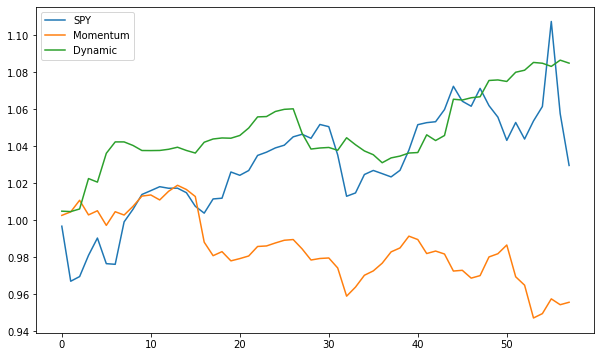

In [24]:
data_pct.dropna(inplace=True)
data_pct.reset_index(drop=True, inplace=True)
bt = back_test(data_pct)
bt[['SPY', 'Momentum', 'Dynamic']].plot(figsize=(10, 6))

In [25]:
std_err = bt[['SPY', 'Momentum', 'Dynamic']].pct_change().std() * 12 ** 0.5
std_err

SPY         0.043979
Momentum    0.023596
Dynamic     0.017578
dtype: float64

In [26]:
ret = (1 / (bt.shape[0] / 12)) * (bt[['SPY', 'Momentum', 'Dynamic']].iloc[-1, :] - 1)
ret

SPY         0.006096
Momentum   -0.009205
Dynamic     0.017538
Name: 57, dtype: float64

In [27]:
sharpe = ret / std_err
sharpe

SPY         0.138617
Momentum   -0.390099
Dynamic     0.997676
dtype: float64

In [28]:
Drawdown = bt[['SPY', 'Momentum', 'Dynamic']].apply(lambda col: max((col.cummax() - col) / col.cummax()))

In [29]:
Metrics = pd.concat([sharpe, ret, std_err, Drawdown], axis=1).rename(columns={0: 'Sharpe', 57: 'Return_Ann', 1: 'Std_err', 2: 'Drawdown'})
Metrics.round(4)

,Sharpe,Return_Ann,Std_err,Drawdown
SPY,0.1386,0.0061,0.0440,0.0703
Momentum,-0.3901,-0.0092,0.0236,0.0704
Dynamic,0.9977,0.0175,0.0176,0.0275
